In [1]:
import camb

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from onepower import Spectra
from params_benchmark import kwargs

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

plt.rcParams.update({'font.size': 16})

In [ ]:
# Common parameters

omega_m = 0.25       # Total matter density (cold dark matter + baryonic matter)
omega_c = 0.2      # Cold dark matter density
omega_b = 0.05      # Baryonic matter density

h0 = 0.8            # Dimensionless Hubble parameter
ns = 0.96            # Spectral index

m_nu = 0.06
n_nu = 3.044

k_lower = -4 # k-range [h/Mpc]
k_upper = 1  # k-range [h/Mpc]

# CAMB settings
# -----------------------
# Cosmology
camb_cosmo = {
    'omch2': omega_c * h0 ** 2,  # - m_nu/93.14,  # Omega_c * h^2 (CDM density)
    'ombh2': omega_b * h0 ** 2,  # Omega_b * h^2 (baryon density)
    'H0': h0 * 100,              # Hubble constant in km/s/Mpc
    'ns': ns,                    # Spectral index
    'As': 2.7e-9,                # Scalar amplitude
    'mnu': m_nu,                 # Sum of neutrino masses in eV
    'omk': 0.0,
    'neutrino_hierarchy': 'degenerate',
    'nnu': n_nu,
    'standard_neutrino_neff': n_nu,
    'TCMB': 2.7255,
}
camb_de = {
    'w': -1.0,
    'wa': 0.0}

# Redshift and k-range settings
z = np.linspace(0, 3, 100)
kmin = 10 ** k_lower
kmax = 10 ** k_upper
nk = 100

# OnePower settings
# -----------------------------
# Cosmology
params_cosmo = {
    'omega_c': omega_c,    # Cold dark matter density
    'omega_b': omega_b,    # Baryonic matter density
    'h0': h0,              # Dimensionless Hubble parameter
    'n_s': ns,             # Spectral index (note different key name than CAMB)
    'tcmb': 2.7255,
    'w0': -1.0,
    'wa': 0.0}

# Power Spectrum
params_pk = {
    'lnk_min': float(np.log(10**(k_lower))),
    'lnk_max': float(np.log(10**(k_upper))),
    'dlnk': 0.01,
    'z_vec': np.array([0.0])}

## CAMB Set up

In [3]:
def compute_growth_factor(r, z, k, kmax):

    P_tot = r.get_matter_power_interpolator(nonlinear=False, extrap_kmax=kmax)

#    Evaluate it at the smallest k
    kmin = k.min()
    P_kmin = P_tot.P(z, kmin)

    D = np.sqrt(P_kmin / P_kmin[0]).squeeze()
    return np.atleast_1d(D)

In [4]:
# =================================================================================
# # HMcode no Feedback

camb_mead2020_no_feedback = camb.set_params(
                                    **camb_cosmo,
                                    halofit_version='mead2020')
camb_mead2020_no_feedback.set_dark_energy(**camb_de)
camb_mead2020_no_feedback.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results_no_feedback = camb.get_results(camb_mead2020_no_feedback)
powerspec = results_no_feedback.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, pk_camb_mead2020_no_feedback = powerspec

# Transfer Function from CAMB (for Onepower)
camb_transfers = camb.get_transfer_functions(camb_mead2020_no_feedback)
transfer_func_mead2020_no_feedback = results_no_feedback.get_matter_transfer_data().transfer_z('delta_tot', -1)
transfer_k_mead2020_no_feedback = results_no_feedback.get_matter_transfer_data().transfer_z('k/h', -1)
camb_growth_mead2020_no_feedback = compute_growth_factor(results_no_feedback, z_, kh, kmax)

# =================================================================================
# HMcode Feedback

camb_mead2020_feedback = camb.set_params(
                                    **camb_cosmo,
                                    halofit_version='mead2020_feedback')
camb_mead2020_feedback.set_dark_energy(**camb_de)
camb_mead2020_feedback.set_matter_power(redshifts=z, kmax=kmax, nonlinear=True)

results_feedback = camb.get_results(camb_mead2020_feedback)
powerspec = results_feedback.get_matter_power_spectrum(minkh=kmin, maxkh=kmax, npoints=nk)
kh, z_, pk_camb_mead2020_feedback = powerspec

# Transfer Function from CAMB (for Onepower)
camb_transfers = camb.get_transfer_functions(camb_mead2020_feedback)
transfer_func_mead2020_feedback = results_feedback.get_matter_transfer_data().transfer_z('delta_tot', -1)
transfer_k_mead2020_feedback = results_feedback.get_matter_transfer_data().transfer_z('k/h', -1)
camb_growth_mead2020_feedback = compute_growth_factor(results_feedback, z_, kh, kmax)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


## OnePower - no $\beta_{nl}$

In [5]:
# =================================================================================
# mead_correction = 'nofeedback'

onepower_nofeedback = Spectra(
        sigma_8=results_no_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_no_feedback,
                         'T': transfer_func_mead2020_no_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_no_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients='mead2020',
        nonlinear_mode='hmcode')

# =================================================================================
# mead_correction = None

onepower_nocorrection = Spectra(
        sigma_8=results_no_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_no_feedback,
                         'T': transfer_func_mead2020_no_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_no_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients=None,
        nonlinear_mode=None)

# =================================================================================
# mead_correction = 'feedback'

onepower_feedback = Spectra(
        sigma_8=results_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_feedback,
                         'T': transfer_func_mead2020_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients='mead2020_feedback',
        nonlinear_mode='hmcode')

# =================================================================================
# mead_correction = 'fit'

onepower_fit = Spectra(
        sigma_8=results_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_feedback,
                         'T': transfer_func_mead2020_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients='fit',
        nonlinear_mode=None)

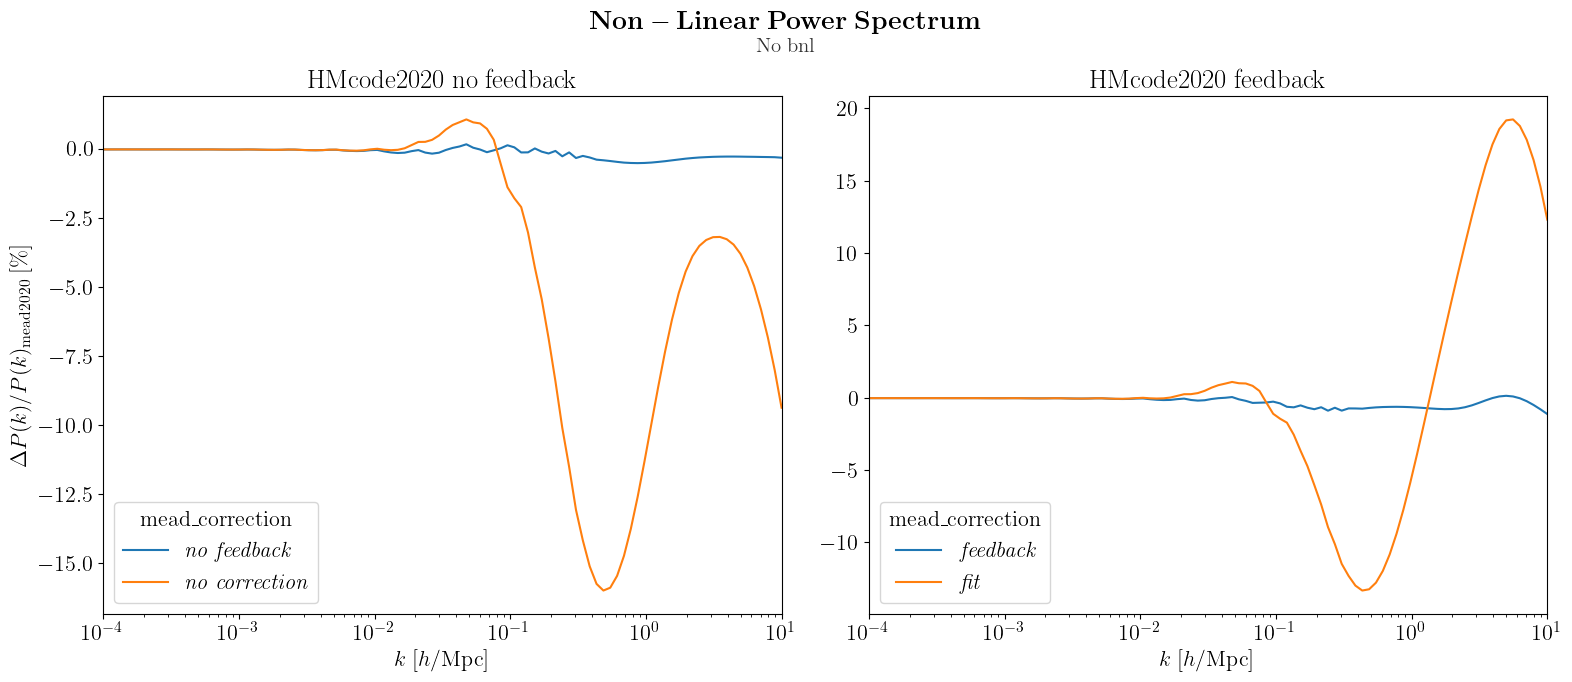

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# =================================================================================
# HMcode no Feedback

diff_nofeedback = (onepower_nofeedback.power_spectrum_mm.pk_tot[0,0,:]
                   - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_nofeedback * 100, label=r'$\mathit{no\ feedback}$')

diff_nocorrection = (onepower_nocorrection.power_spectrum_mm.pk_tot[0,0,:]
                     - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_nocorrection * 100, label=r'$\mathit{no\ correction}$')

# =================================================================================
# HMcode Feedback

diff_feedback = (onepower_feedback.power_spectrum_mm.pk_tot[0,0,:]
                 - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_feedback * 100, label=r'$\mathit{feedback}$')

diff_fit = (onepower_fit.power_spectrum_mm.pk_tot[0,0,:]
            - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_fit * 100, label=r'$\mathit{fit}$')

# =================================================================================

ax1.legend(title=r'$\mathrm{mead\_ correction}$', loc='lower left')
ax2.legend(title=r'$\mathrm{mead\_ correction}$', loc='lower left')

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)_{\mathrm{mead2020}}\ [\%]$',
        title=r'$\mathrm{HMcode2020\ no\ feedback}$')

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=r'$\mathrm{HMcode2020\ feedback}$')

fig.suptitle(r'$\mathbf{Non-Linear\ Power\ Spectrum}$')
fig.text(0.5, 0.92, r'$\mathrm{No\ bnl}$',
         fontsize=15, ha='center', alpha=0.8)

plt.tight_layout()
plt.savefig('Pk_Nonlinear_no_bnl.pdf',
            bbox_inches='tight',
            dpi=300)

plt.show()

#### same plot, but zoomed in

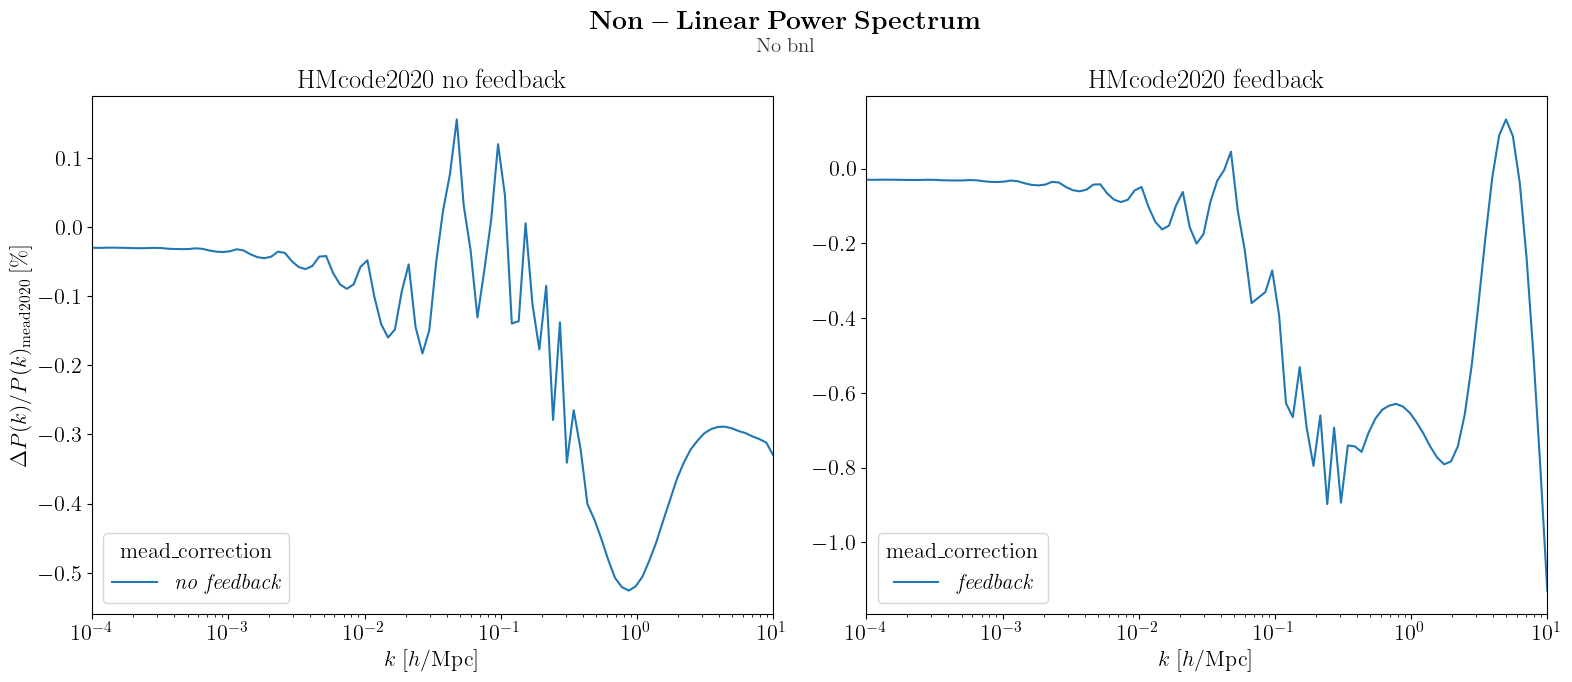

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

ax1.plot(kh, diff_nofeedback * 100, label=r'$\mathit{no\ feedback}$')
ax2.plot(kh, diff_feedback * 100, label=r'$\mathit{feedback}$')

ax1.legend(title=r'$\mathrm{mead\_ correction}$', loc='lower left')
ax2.legend(title=r'$\mathrm{mead\_ correction}$', loc='lower left')

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)_{\mathrm{mead2020}}\ [\%]$',
        title=r'$\mathrm{HMcode2020\ no\ feedback}$')

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=r'$\mathrm{HMcode2020\ feedback}$')

fig.suptitle(r'$\mathbf{Non-Linear\ Power\ Spectrum}$')
fig.text(0.5, 0.92, r'$\mathrm{No\ bnl}$',
         fontsize=15, ha='center', alpha=0.8)

plt.tight_layout()
plt.savefig('Pk_Nonlinear_no_bnl_zoomed.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

## OnePower - with $\beta_{nl}$

In [8]:
# =================================================================================
# mead_correction = 'nofeedback'

onepower_nofeedback_bnl = Spectra(
        sigma_8=results_no_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_no_feedback,
                         'T': transfer_func_mead2020_no_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_no_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients='mead2020',
        nonlinear_mode='bnl')

# =================================================================================
# mead_correction = None

onepower_nocorrection_bnl = Spectra(
        sigma_8=results_no_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_no_feedback,
                         'T': transfer_func_mead2020_no_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_no_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients=None,
        nonlinear_mode='bnl')

# =================================================================================
# mead_correction = 'feedback'

onepower_feedback_bnl = Spectra(
        sigma_8=results_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_feedback,
                         'T': transfer_func_mead2020_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients='mead2020_feedback',
        nonlinear_mode='bnl')

# =================================================================================
# mead_correction = 'fit'

onepower_fit_bnl = Spectra(
        sigma_8=results_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_feedback,
                         'T': transfer_func_mead2020_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_feedback},
        dewiggle=True,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients='fit',
        nonlinear_mode='bnl')


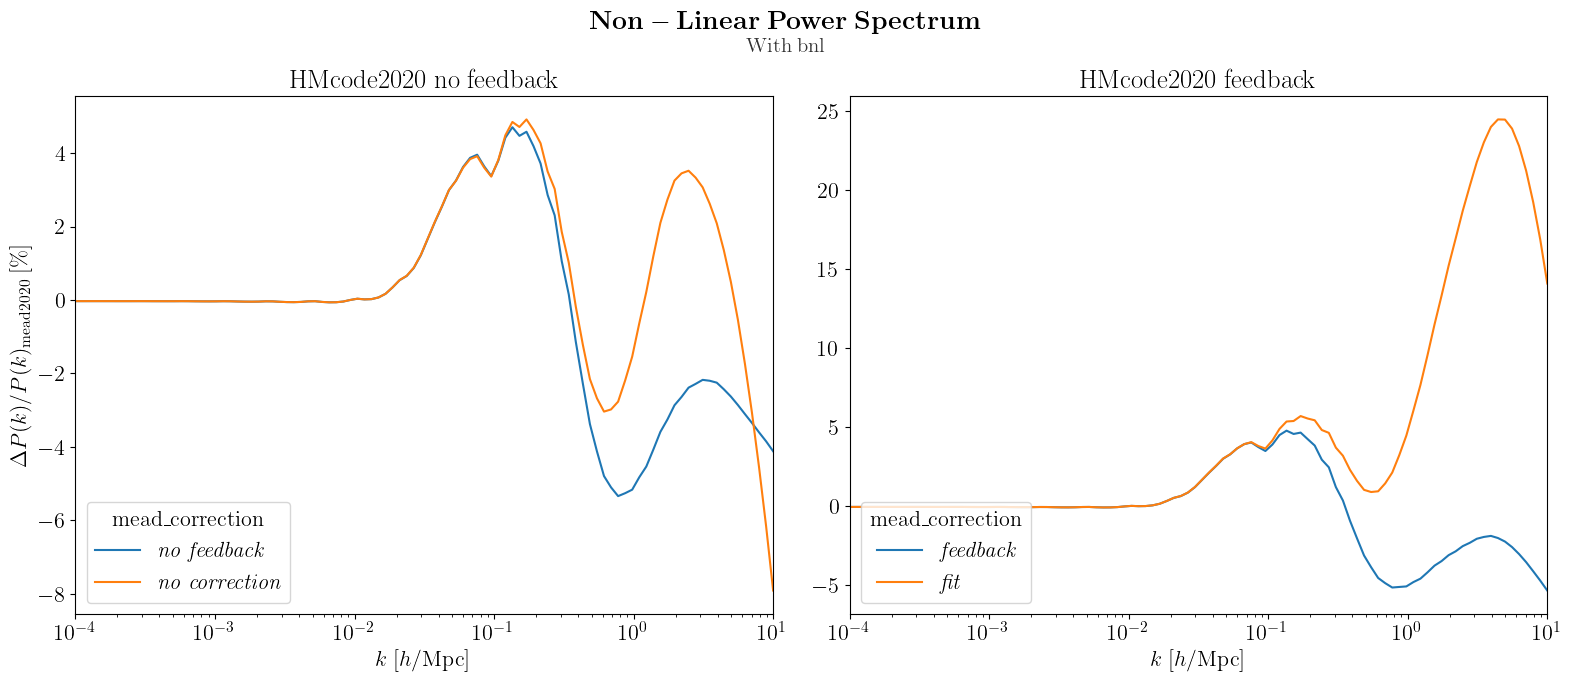

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# =================================================================================
# HMcode no Feedback

diff_nofeedback_bnl = (onepower_nofeedback_bnl.power_spectrum_mm.pk_tot[0,0,:]
                       - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_nofeedback_bnl * 100, label=r'$\mathit{no\ feedback}$')

diff_nocorrection_bnl = (onepower_nocorrection_bnl.power_spectrum_mm.pk_tot[0,0,:]
                         - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_nocorrection_bnl * 100, label=r'$\mathit{no\ correction}$')

# =================================================================================
# HMcode Feedback

diff_feedback_bnl = (onepower_feedback_bnl.power_spectrum_mm.pk_tot[0,0,:]
                     - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_feedback_bnl * 100, label=r'$\mathit{feedback}$')

diff_fit_bnl = (onepower_fit_bnl.power_spectrum_mm.pk_tot[0,0,:]
                - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_fit_bnl * 100, label=r'$\mathit{fit}$')

# =================================================================================

ax1.legend(title=r'$\mathrm{mead\_ correction}$', loc='lower left')
ax2.legend(title=r'$\mathrm{mead\_ correction}$', loc='lower left')

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)_{\mathrm{mead2020}}\ [\%]$',
        title=r'$\mathrm{HMcode2020\ no\ feedback}$')

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=r'$\mathrm{HMcode2020\ feedback}$')

fig.suptitle(r'$\mathbf{Non-Linear\ Power\ Spectrum}$')
fig.text(0.5, 0.92, r'$\mathrm{With\ bnl}$',
         fontsize=15, ha='center', alpha=0.8)

plt.tight_layout()
plt.savefig('Pk_Nonlinear_bnl.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

## Combined plots

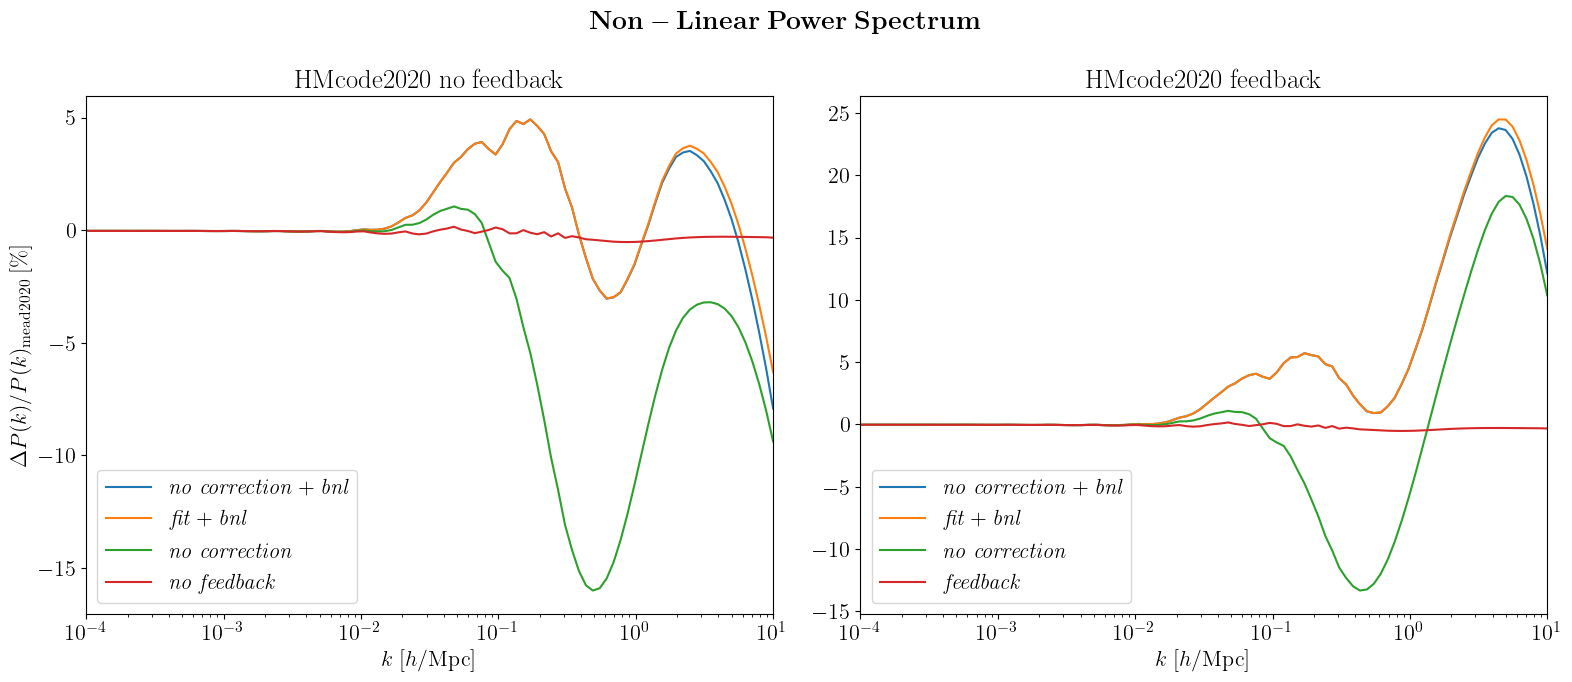

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# =================================================================================
# HMcode no Feedback

diff_nocorrection_bnl = (onepower_nocorrection_bnl.power_spectrum_mm.pk_tot[0,0,:]
                         - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_nocorrection_bnl * 100, label=r'$\mathit{no\ correction}+\mathit{bnl}$')

diff_fit_bnl = (onepower_fit_bnl.power_spectrum_mm.pk_tot[0,0,:]
                - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_fit_bnl * 100, label=r'$\mathit{fit}+\mathit{bnl}$')

diff_nocorrection = (onepower_nocorrection.power_spectrum_mm.pk_tot[0,0,:]
                     - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_nocorrection * 100, label=r'$\mathit{no\ correction}$')

diff_nofeedback = (onepower_nofeedback.power_spectrum_mm.pk_tot[0,0,:]
                   - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax1.plot(kh, diff_nofeedback * 100, label=r'$\mathit{no\ feedback}$')

# =================================================================================
# HMcode Feedback

diff_nocorrection_bnl = (onepower_nocorrection_bnl.power_spectrum_mm.pk_tot[0,0,:]
                         - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_nocorrection_bnl * 100, label=r'$\mathit{no\ correction}+\mathit{bnl}$')

diff_fit_bnl = (onepower_fit_bnl.power_spectrum_mm.pk_tot[0,0,:]
                - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_fit_bnl * 100, label=r'$\mathit{fit}+\mathit{bnl}$')

diff_nocorrection = (onepower_nocorrection.power_spectrum_mm.pk_tot[0,0,:]
                     - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_nocorrection * 100, label=r'$\mathit{no\ correction}$')

diff_feedback = (onepower_feedback.power_spectrum_mm.pk_tot[0,0,:]
                 - pk_camb_mead2020_feedback[0])/pk_camb_mead2020_feedback[0]
ax2.plot(kh, diff_nofeedback * 100, label=r'$\mathit{feedback}$')

# =================================================================================

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)_{\mathrm{mead2020}}\ [\%]$',
        title=r'$\mathrm{HMcode2020\ no\ feedback}$')

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=r'$\mathrm{HMcode2020\ feedback}$')

fig.suptitle(r'$\mathbf{Non-Linear\ Power\ Spectrum}$')

plt.tight_layout()
plt.savefig('Pk_Nonlinear_comparison.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

#### same plot, but zoomed in

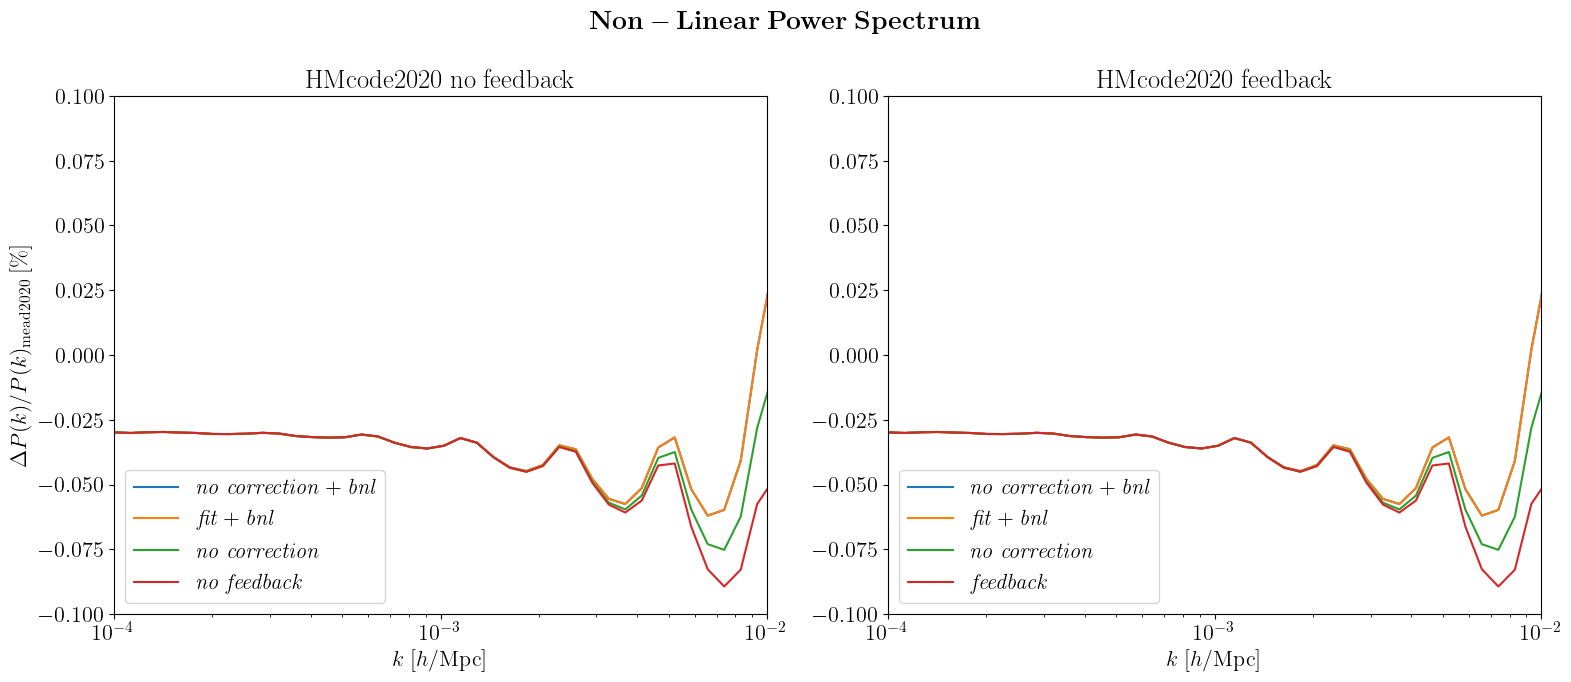

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# =================================================================================
# HMcode no Feedback

ax1.plot(kh, diff_nocorrection_bnl * 100, label=r'$\mathit{no\ correction}+\mathit{bnl}$')
ax1.plot(kh, diff_fit_bnl * 100, label=r'$\mathit{fit}+\mathit{bnl}$')
ax1.plot(kh, diff_nocorrection * 100, label=r'$\mathit{no\ correction}$')
ax1.plot(kh, diff_nofeedback * 100, label=r'$\mathit{no\ feedback}$')

# =================================================================================
# HMcode Feedback

ax2.plot(kh, diff_nocorrection_bnl * 100, label=r'$\mathit{no\ correction}+\mathit{bnl}$')
ax2.plot(kh, diff_fit_bnl * 100, label=r'$\mathit{fit}+\mathit{bnl}$')
ax2.plot(kh, diff_nocorrection * 100, label=r'$\mathit{no\ correction}$')
ax2.plot(kh, diff_nofeedback * 100, label=r'$\mathit{feedback}$')

# =================================================================================

ax1.legend(loc='lower left')
ax2.legend(loc='lower left')

ax1.set(xlim=(1e-4, 1e-2),
        ylim=(-0.1, 0.1),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)_{\mathrm{mead2020}}\ [\%]$',
        title=r'$\mathrm{HMcode2020\ no\ feedback}$')

ax2.set(xlim=(1e-4, 1e-2),
        ylim=(-0.1, 0.1),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        title=r'$\mathrm{HMcode2020\ feedback}$')

fig.suptitle(r'$\mathbf{Non-Linear\ Power\ Spectrum}$')

plt.tight_layout()
plt.savefig('Pk_Nonlinear_comparison_zoomed.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()

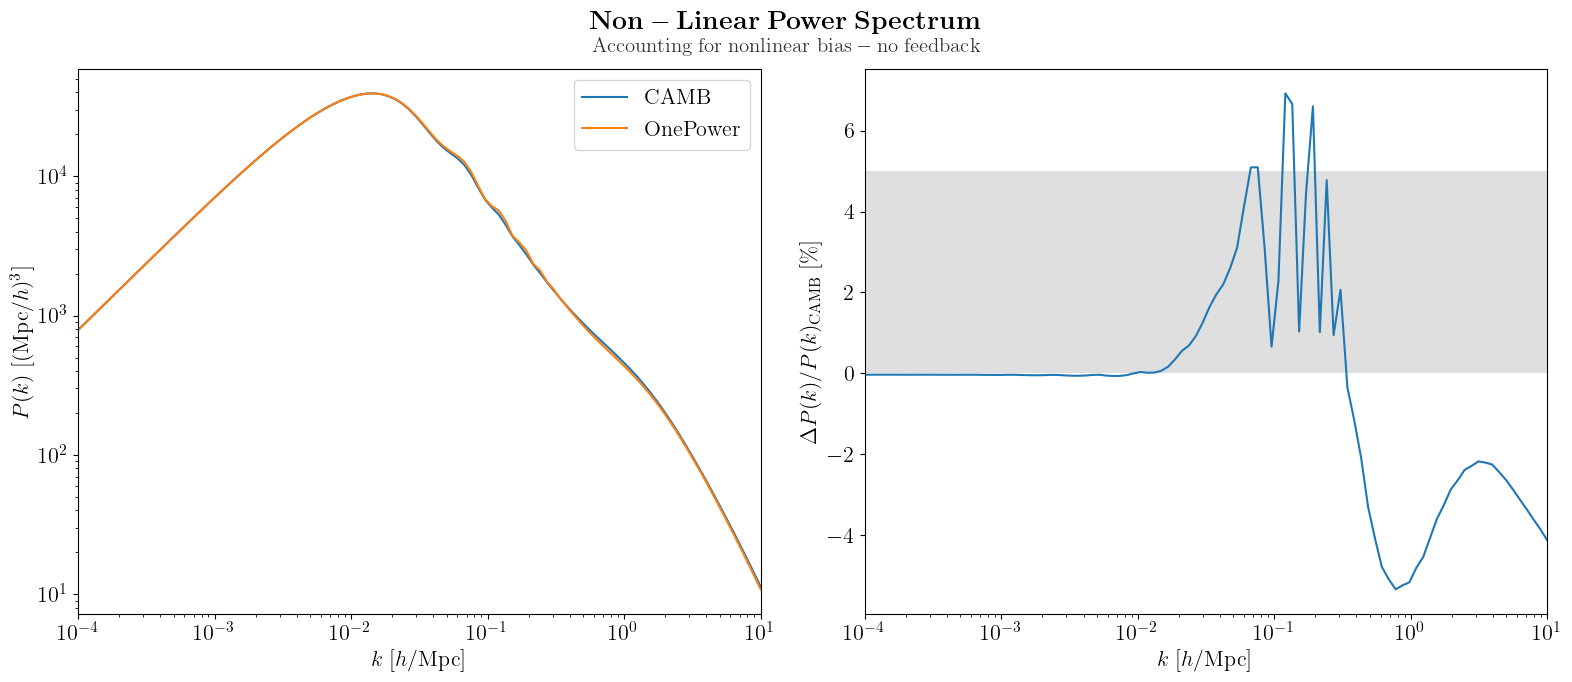

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# =================================================================================
# Checking the non-linear bias
# =================================================================================

ax1.plot(kh, pk_camb_mead2020_no_feedback[0], label=r'$\mathrm{CAMB}$')

model_bnl = Spectra(
        sigma_8=results_no_feedback.get_sigma8_0(),
        transfer_model='FromArray',
        transfer_params={'k': transfer_k_mead2020_no_feedback,
                         'T': transfer_func_mead2020_no_feedback},
        growth_model='FromArray',
        growth_params={'z': z,
                       'd': camb_growth_mead2020_no_feedback},
        dewiggle=False,
        **params_cosmo, **params_pk,
        k_vec=kh,
        hmcode_ingredients='mead2020',
        nonlinear_mode='bnl')

ax1.plot(model_bnl.k_vec, model_bnl.power_spectrum_mm.pk_tot[0,0,:],
         label=r'$\mathrm{OnePower}$')

# Relative Differences
diff = (model_bnl.power_spectrum_mm.pk_tot[0,0,:]
        - pk_camb_mead2020_no_feedback[0])/pk_camb_mead2020_no_feedback[0]
ax2.plot(kh, diff * 100)

ax2.axhspan(0.0, 5.0, facecolor='gray', alpha=0.25)

ax1.legend()

ax1.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        yscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$P(k) \ [(\mathrm{Mpc}/h)^3]$')

ax2.set(xlim=(10.0**k_lower, 10.0**k_upper),
        xscale='log',
        xlabel=r'$k \ [h/\mathrm{Mpc}]$',
        ylabel=r'$\Delta P(k) / P(k)_{\mathrm{CAMB}}\ [\%]$')

fig.suptitle(r'$\mathbf{Non-Linear\ Power\ Spectrum}$')
fig.text(0.5, 0.92, r'$\mathrm{Accounting\ for\ nonlinear\ bias - no\ feedback}$',
         fontsize=15, ha='center', alpha=0.8)

plt.tight_layout()
plt.savefig('Pk_Nonlinear_bnl_nofeedback.pdf',
            bbox_inches='tight',
            dpi=300)
plt.show()